In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys # used in command to make entire array print by default
import seaborn as sns

# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

In [2]:
def lregressiontest(df,xfeatures,yfeature,train_size):
    y = df[yfeature]
    X = filter_columns(df,xfeatures)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    column_names = X_train.columns
    r_and_p_values = [pearsonr(X_train[col], y_train) for col in column_names]
    corrdict = dict(zip(column_names, r_and_p_values))

    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    lm1 = LinearRegression(fit_intercept=False) 
    lm1.fit(X_train[xfeatures], y_train)
    LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
    lm1_y_intercept = lm1.intercept_
    lm1_coefficients = lm1.coef_
    y_pred_lm1 = lm1.predict(X_train[xfeatures])
    mse = mean_squared_error(y_train, y_pred_lm1)
    r2 = r2_score(y_train, y_pred_lm1)
    return mse, r2, corrdict




def linreg(X_train, y_train):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_train)
    MAE = median_absolute_error(y_train, y_pred)
    MSE = mean_squared_error(y_train, y_pred)
    r2_train = r2_score(y_train, y_pred)
    scatter = sns.scatterplot(x = y_train.recovery, y = y_pred.ravel())
    reg_df = pd.DataFrame(lr.coef_, columns=X_vars)
    reg_df = reg_df.transpose().sort_values(by=0, ascending=False)
    reg_df.rename(index=str, columns={0: 'value'}, inplace=True)
    abs_df = reg_df.copy()
    abs_df['value'] = abs(abs_df['value'])
    abs_df.sort_values(by='value', ascending=False)
    return reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter

def ridge(X_train, y_train):
    rr = Ridge(alpha=.5)
    rr.fit(X_train, y_train)
    y_pred = rr.predict((X_train))
    MAE = median_absolute_error(y_train, y_pred)
    MSE = mean_squared_error(y_train, y_pred)
    scatter = sns.scatterplot(x = y_train, y = y_pred.ravel())
    return rr, rr.coef_, rr.intercept_, MAE, MSE, y_pred, scatter

def svm(X_train, y_train):
    svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    svr_lin = SVR(kernel='linear', C=100, gamma='auto')
    svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)
    y_rbf = svr_rbf.fit(X_train, y_train).predict(X_train)
    y_lin = svr_lin.fit(X_train, y_train).predict(X_train)
    y_poly = svr_poly.fit(X_train, y_train).predict(X_train)
    MSE_rbf = mean_squared_error(y_train, y_rbf)
    MSE_lin = mean_squared_error(y_train, y_lin)
    MSE_poly = mean_squared_error(y_train, y_poly)
    return svr_rbf, svr_lin, svr_poly, MSE_rbf, MSE_lin, MSE_poly, y_rbf, y_lin, y_poly

In [3]:
df = acquire_oil()
df = prep_data(df)
df.reset_index(inplace=True)
df.shape

(7888, 63)

In [4]:
df.isnull().sum()

index                      0
api14                      0
lease_name                 0
well_number                0
county                     0
direction                  0
status                     0
oper                       0
multi_well_lease           0
major_phase                0
formation                  0
proppant_ppf               0
prod_method                0
frac_fluid_gpf             0
gross_perfs                0
frac_stages                0
frac_fluid_type            0
first_prod                 0
last_prod                  0
oil_gravity                0
peak_boepd                 0
oil_hist                   0
gas_hist                   0
gor_hist                   0
ip90_boeqpd                0
tvd                        0
sur_lat                    0
sur_long                   0
well_id                    0
mid_point_lat              0
                          ..
recovery_per_foot          0
months_active              0
recovery_per_month         0
lateral_class 

In [5]:
df.drop(columns=['api14', 'sur_lat', 'sur_long', 'well_id']).describe()

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,oil_hist,gas_hist,gor_hist,ip90_boeqpd,...,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
count,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,...,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000
mean,1129.177020,1142.213462,5732.858773,3.204488,1.862447,508.725133,120.070635,385.288562,3888.944514,349.246186,...,0.284274,0.380934,0.421953,0.045778,0.027389,0.194749,0.520577,0.393372,0.647040,0.895554
std,656.539972,714.303891,2945.296014,9.336062,9.188722,443.645469,95.660116,387.207769,3815.982884,315.135247,...,0.165447,0.238298,0.216933,0.133372,0.135128,0.191106,0.254807,0.145262,0.208235,0.136712
min,1.098097,0.354610,4.000000,0.000000,0.000000,0.663017,0.031000,0.001000,0.212134,0.001812,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,525.892109,499.423181,4056.250000,0.000000,0.000000,159.810463,46.481500,110.739000,1422.937793,94.906605,...,0.132247,0.166494,0.298464,0.000000,0.000000,0.071251,0.462055,0.280652,0.579955,0.900000
50%,1156.356260,1222.371400,6242.000000,0.000000,0.000000,429.084519,101.236000,284.305000,2491.502805,292.328796,...,0.291123,0.407675,0.459453,0.000000,0.000000,0.124765,0.589809,0.383685,0.696075,0.933333
75%,1594.793975,1653.074860,7723.250000,0.000000,0.000000,732.588900,172.310750,542.369000,4906.603828,508.700090,...,0.401608,0.551362,0.568553,0.000000,0.000000,0.245714,0.693837,0.478842,0.797456,0.950000
max,3969.384520,2997.879640,13581.000000,70.000000,68.000000,6118.757000,754.662000,4007.768000,19968.130000,4752.926000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Create Dataframe with Numeric Data

In [6]:
numerics = ['int64', 'float64', 'float']

scaled_df = df.select_dtypes(include=numerics)
scaled_df = scaled_df.drop(columns=['api14', 'proppant_ppf', 'frac_fluid_gpf', 
        'gross_perfs', 'frac_stages', 'oil_gravity', 'peak_boepd', 'oil_hist', 
        'gas_hist', 'gor_hist', 'ip90_boeqpd', 'tvd', 'sur_lat', 'sur_long', 
        'well_id', 'mid_point_lat', 'mid_point_long', 'recovery_per_foot', 
        'months_active', 'recovery_per_month', 'vintage', 'vintage_bin', 
        'encoded_direction', 'encoded_frac_fluid_type', 'encoded_county', 
        'encoded_oper', 'encoded_formation', 'encoded_sub_basin', 'encoded_lateral_class', 
        'scaled_mid_point_long', 'scaled_mid_point_lat', 'scaled_county'])

In [7]:
scaled_df.columns

Index(['recovery', 'scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper',
       'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class',
       'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs',
       'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist',
       'scaled_tvd', 'scaled_vintage'],
      dtype='object')

## Scale the gross_perfs limit:

In [8]:
df.gross_perfs.min()

4.0

In [9]:
df.gross_perfs.max()

13581.0

In [10]:
gross_perfs_scaled_limit = (6000 - df.gross_perfs.min()) / (df.gross_perfs.max() - df.gross_perfs.min())

In [11]:
gross_perfs_scaled_limit

0.44162922589673714

In [12]:
scaled_df.sample(10)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_vintage
4930,442.353500,0.0,0.375,0.590909,0.763158,1.0,0.692308,0.448132,0.632099,0.700228,0.000000,0.0,0.094659,0.671952,0.950000
7082,246.568347,0.0,0.375,0.768939,0.763158,0.5,0.153846,0.103998,0.125568,0.337188,0.114286,0.0,0.166124,0.827229,0.900000
3311,98.878839,0.0,0.875,0.196970,0.631579,1.0,0.615385,0.362235,0.540316,0.385652,0.000000,0.0,0.058323,0.667634,0.950000
4090,9.567500,1.0,0.000,0.295455,0.157895,1.0,0.461538,0.050600,0.039346,0.023054,0.000000,0.0,0.228753,0.000000,0.900000
802,97.909836,0.0,0.875,0.465909,0.447368,1.0,0.230769,0.296542,0.607005,0.267217,0.000000,0.0,0.145342,0.718401,0.900000
464,76.108836,0.0,0.375,0.314394,0.763158,1.0,0.000000,0.348547,0.336026,0.534139,0.428571,0.0,0.320025,0.484740,0.933333
1592,68.700167,1.0,0.000,0.973485,0.763158,1.0,0.461538,0.650825,0.002915,0.011858,0.000000,0.0,0.924330,0.000000,0.700000
2189,220.226677,0.0,0.375,0.340909,0.763158,1.0,0.000000,0.365425,0.349432,0.533328,0.000000,0.0,0.923067,0.479604,0.933333
5166,41.951502,0.0,0.875,0.465909,0.763158,1.0,0.384615,0.459695,0.782411,0.635486,0.000000,0.0,0.090932,0.556275,0.983333
4154,57.689833,1.0,0.250,0.628788,0.631579,1.0,1.000000,0.074211,0.041197,0.117257,0.000000,0.0,0.468335,0.000000,0.666667


## Visualize Data

### Attribute Histograms

In [13]:
scaled_df.columns

Index(['recovery', 'scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper',
       'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class',
       'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs',
       'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist',
       'scaled_tvd', 'scaled_vintage'],
      dtype='object')

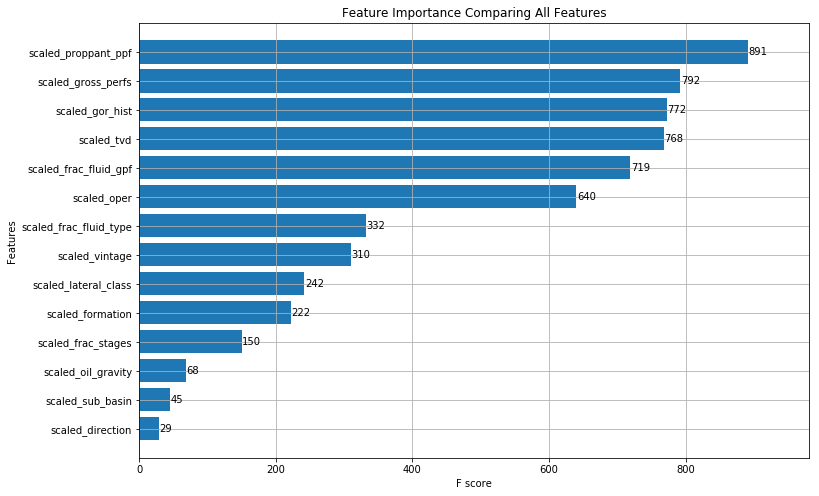

In [14]:
xgb_df = scaled_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, scaled_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance Comparing All Features')
plt.show()

# I think we can return xgb and model to then plot xgb.plot_importance(model,...)
# Or maybe can save that line into a variable to return.

Top recommended features without any partitions:

X_vars = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_gor_hist', 'scaled_tvd',
          'scaled_frac_fluid_gpf', 'scaled_oper']

#### Run the regression with all of the features:

lr.intercept: 31.908667415222595
MAE: 47.76523161662959
MSE: 13834.581670972819
r2_train: 0.2907999819629814


,value
scaled_gross_perfs,258.452403
scaled_oil_gravity,231.070771
scaled_tvd,223.849616
scaled_direction,98.684184
scaled_formation,30.988751
scaled_gor_hist,28.532000
scaled_frac_fluid_gpf,23.221990
scaled_proppant_ppf,4.672893
scaled_lateral_class,-2.677519
scaled_frac_fluid_type,-4.376679


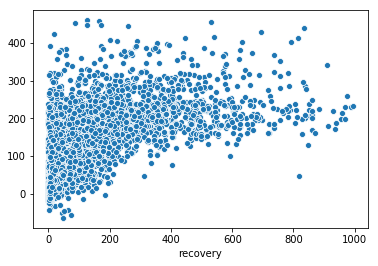

In [15]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = scaled_df[X_vars].copy()                                                    
y = scaled_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [16]:
print('ranked by absolute value of coefficient:')
abs_df.sort_values(by='value', ascending=False)

ranked by absolute value of coefficient:


,value
scaled_gross_perfs,258.452403
scaled_oil_gravity,231.070771
scaled_tvd,223.849616
scaled_vintage,126.441002
scaled_direction,98.684184
scaled_sub_basin,43.932596
scaled_frac_stages,31.924347
scaled_formation,30.988751
scaled_gor_hist,28.532000
scaled_frac_fluid_gpf,23.221990


#### Filter all features for only vertical wells:

lr.intercept: 83.68398332444022
MAE: 15.185668349250545
MSE: 989.1565423557266
r2_train: 0.36947662389901137


,value
scaled_gross_perfs,298.648281
scaled_tvd,43.529288
scaled_frac_fluid_gpf,35.801580
scaled_gor_hist,31.883224
scaled_formation,27.173436
scaled_sub_basin,2.738223
scaled_frac_fluid_type,0.424754
scaled_direction,0.000000
scaled_oper,-4.133982
scaled_proppant_ppf,-14.279613


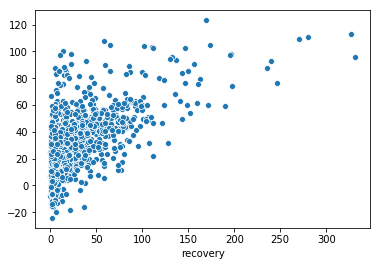

In [17]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

# These lines are to filter for only vertical wells:
df_vert = scaled_df[scaled_df.scaled_direction == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [18]:
print('ranked by absolute value of coefficient:')
abs_df.sort_values(by='value', ascending=False)

ranked by absolute value of coefficient:


,value
scaled_frac_stages,585.186580
scaled_gross_perfs,298.648281
scaled_vintage,115.334012
scaled_tvd,43.529288
scaled_oil_gravity,36.984091
scaled_frac_fluid_gpf,35.801580
scaled_gor_hist,31.883224
scaled_formation,27.173436
scaled_lateral_class,18.000303
scaled_proppant_ppf,14.279613


#### Test only top features suggested by XGBoost, without filtering for vertical wells.

lr.intercept: 6.477454797176733
MAE: 54.530739233891566
MSE: 15053.831869050246
r2_train: 0.22494694896073408


,value
scaled_tvd,153.990747
scaled_gross_perfs,137.557961
scaled_gor_hist,57.305621
scaled_frac_fluid_gpf,13.958150
scaled_proppant_ppf,3.311720
scaled_oper,-24.746869


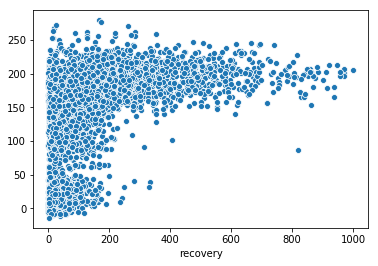

In [19]:
# Independent variables:
X_vars = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_gor_hist', 'scaled_tvd', 
          'scaled_frac_fluid_gpf', 'scaled_oper']
# Dependent (target) variable, it is continuous
target = ['recovery']

X = scaled_df[X_vars].copy()                                                    
y = scaled_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [20]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_tvd,153.990747
scaled_gross_perfs,137.557961
scaled_gor_hist,57.305621
scaled_oper,24.746869
scaled_frac_fluid_gpf,13.958150
scaled_proppant_ppf,3.311720


#### Test only top features suggested by XGBoost (exclude peak_boepd), WITH filtering for vertical wells.

lr.intercept: 13.605719229446052
MAE: 18.45696902139535
MSE: 1495.3947096910908
r2_train: 0.11327808830457431


,value
scaled_gross_perfs,150.686923
scaled_gor_hist,62.813627
scaled_tvd,28.791696
scaled_oper,6.281794
scaled_frac_fluid_gpf,-2.036464
scaled_proppant_ppf,-19.510448


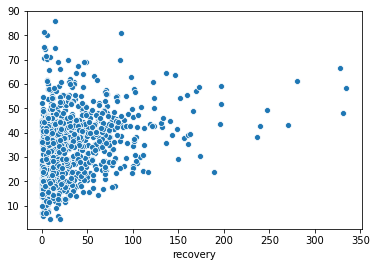

In [21]:
# Independent variables:
X_vars = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_gor_hist', 'scaled_tvd', 
          'scaled_frac_fluid_gpf', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

df_vert = scaled_df[scaled_df.scaled_direction == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[['recovery']]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [22]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_gross_perfs,150.686923
scaled_gor_hist,62.813627
scaled_tvd,28.791696
scaled_proppant_ppf,19.510448
scaled_oper,6.281794
scaled_frac_fluid_gpf,2.036464


# Run XGBoost for each sub-basin:

#### CP, Central Platform, including all features:

In [23]:
CP_df = scaled_df[(scaled_df['scaled_sub_basin'] == 0)]
CP_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_vintage
6296,90.215167,0.0,0.875,0.481061,0.552632,0.0,0.230769,0.060768,0.094053,0.285998,0.085714,0.0,0.024190,0.336088,0.933333
6674,347.862722,0.0,0.375,0.310606,0.184211,0.0,0.230769,0.052731,0.089507,0.275908,0.000000,0.0,0.164781,0.627884,0.766667
6442,85.640833,0.0,0.375,0.579545,0.736842,0.0,0.153846,0.434402,0.922891,0.333873,0.000000,0.0,0.017719,0.515855,0.983333
6492,70.173171,0.0,0.000,0.011364,0.289474,0.0,0.153846,0.038020,0.036731,0.317891,0.000000,0.0,0.049402,0.232247,0.883333
6225,117.282833,0.0,0.375,1.000000,0.631579,0.0,0.000000,0.364924,0.574235,0.558150,0.000000,0.0,0.161025,0.539452,0.916667


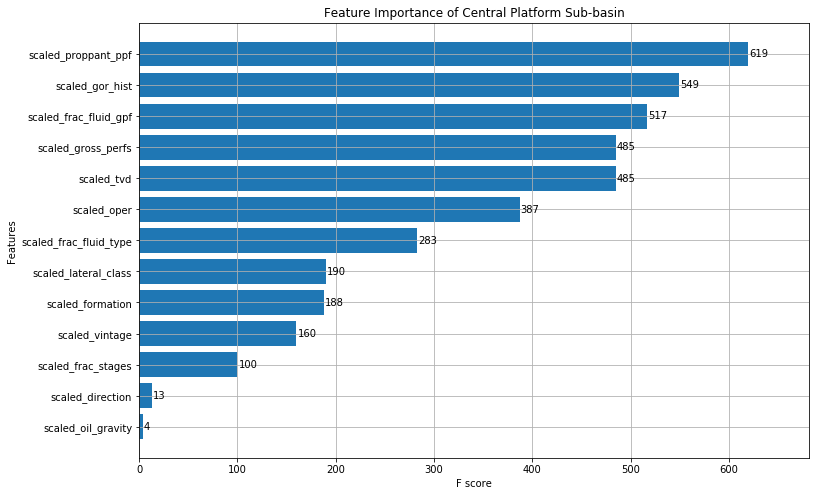

In [24]:
xgb_df = CP_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, CP_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of Central Platform Sub-basin')
plt.show()

lr.intercept: 211.83883111815277
MAE: 41.15690055233378
MSE: 8747.617042214368
r2_train: 0.16461103712213887


,value
scaled_gross_perfs,1.867287e+02
scaled_frac_fluid_gpf,1.345143e+02
scaled_gor_hist,1.131654e+02
scaled_tvd,9.995775e+01
scaled_oil_gravity,8.127444e+01
scaled_lateral_class,2.229064e+01
scaled_frac_fluid_type,1.168812e+01
scaled_formation,1.129559e+01
scaled_sub_basin,-1.527667e-13
scaled_frac_stages,-2.054292e+01


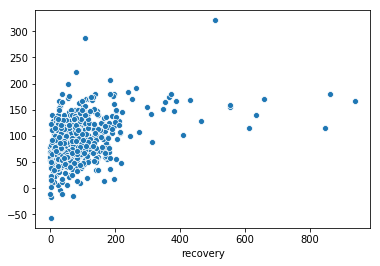

In [25]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = CP_df[X_vars].copy()                                                    
y = CP_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [26]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_vintage,2.484540e+02
scaled_proppant_ppf,2.469575e+02
scaled_gross_perfs,1.867287e+02
scaled_frac_fluid_gpf,1.345143e+02
scaled_gor_hist,1.131654e+02
scaled_tvd,9.995775e+01
scaled_oil_gravity,8.127444e+01
scaled_oper,4.448608e+01
scaled_direction,3.267728e+01
scaled_lateral_class,2.229064e+01


#### Delaware:

In [27]:
Del_df = scaled_df[(scaled_df['scaled_sub_basin'] == 0.5)]
Del_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_vintage
7721,63.556670,0.0,0.875,0.196970,0.763158,0.5,0.538462,0.018450,0.018993,0.508139,0.000000,0.000000,0.055104,0.925190,0.983333
7155,194.894839,0.0,0.000,0.007576,0.052632,0.5,0.230769,0.154757,0.649592,0.270752,0.085714,0.745588,0.833439,0.631755,0.916667
7185,70.926503,0.0,0.375,0.250000,0.052632,0.5,0.230769,0.063978,0.070887,0.277307,0.000000,0.000000,0.081585,0.809364,0.900000
6942,589.694067,0.0,0.375,0.170455,0.763158,0.5,0.538462,0.062704,0.136490,0.496575,0.000000,0.000000,0.074124,0.655054,0.900000
7388,884.331894,0.0,0.875,0.196970,0.763158,0.5,0.153846,0.409552,0.639329,0.335568,0.000000,0.000000,0.080418,0.913950,0.950000


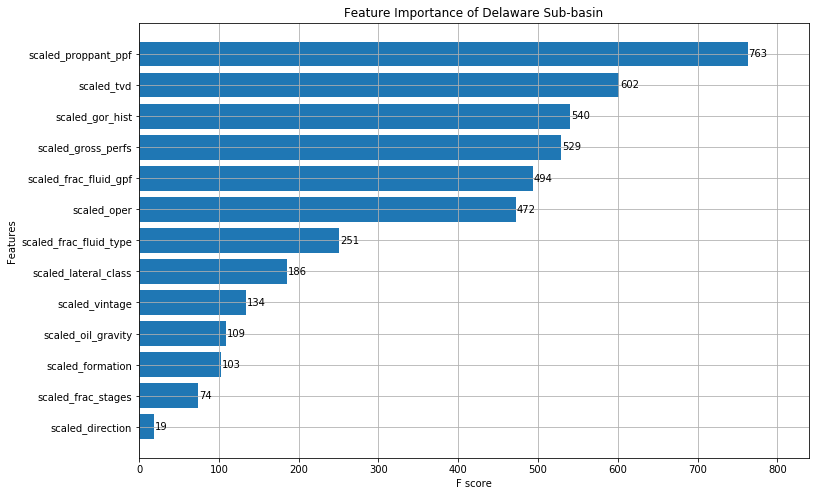

In [28]:
xgb_df = Del_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Del_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of Delaware Sub-basin')
plt.show()

# I think we can return xgb and model to then plot xgb.plot_importance(model,...)
# Or maybe can save that line into a variable to return.

lr.intercept: 926.6402765255177
MAE: 82.63543634370907
MSE: 24059.95420511874
r2_train: 0.25987510869315966


,value
scaled_tvd,2.035606e+02
scaled_frac_stages,1.585074e+02
scaled_proppant_ppf,1.379418e+02
scaled_oil_gravity,1.266023e+02
scaled_gor_hist,9.615597e+01
scaled_gross_perfs,7.463723e+01
scaled_formation,5.914834e+01
scaled_frac_fluid_gpf,5.749178e+01
scaled_frac_fluid_type,8.064662e-01
scaled_sub_basin,2.735590e-13


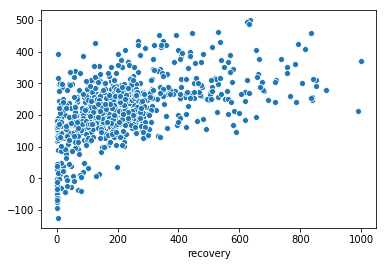

In [29]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Del_df[X_vars].copy()                                                    
y = Del_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [30]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_vintage,1.008222e+03
scaled_tvd,2.035606e+02
scaled_lateral_class,1.785196e+02
scaled_frac_stages,1.585074e+02
scaled_proppant_ppf,1.379418e+02
scaled_oil_gravity,1.266023e+02
scaled_gor_hist,9.615597e+01
scaled_oper,9.521804e+01
scaled_gross_perfs,7.463723e+01
scaled_formation,5.914834e+01


#### Midland:

In [31]:
Mid_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1)]
Mid_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_vintage
5291,81.891170,0.0,0.750,0.443182,0.657895,1.0,0.846154,0.027129,0.037756,0.166311,0.0,0.0,0.119746,0.517493,0.833333
2543,202.320667,0.0,0.375,0.628788,0.763158,1.0,0.000000,0.281393,0.339126,0.530161,0.0,0.0,0.110402,0.696516,0.933333
4038,1.358167,1.0,0.500,0.628788,0.631579,1.0,0.461538,0.032380,0.022579,0.067909,0.0,0.0,0.205841,0.000000,0.700000
2398,157.998508,0.0,0.875,0.863636,0.763158,1.0,0.000000,0.361636,0.510455,0.523017,0.0,0.0,0.186705,0.460027,0.950000
3807,106.777343,0.0,0.875,0.196970,0.631579,1.0,0.076923,0.541384,0.813498,0.757605,0.0,0.0,0.105274,0.662052,0.983333


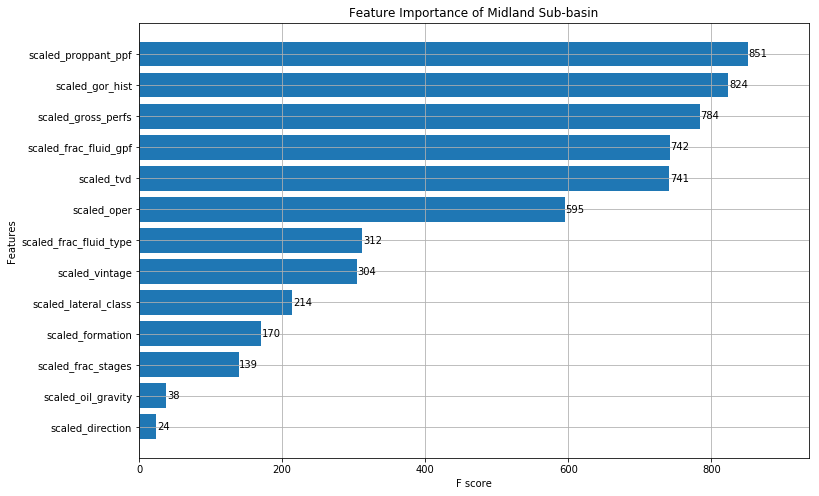

In [32]:
xgb_df = Mid_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of Midland Sub-basin')
plt.show()

lr.intercept: -22.381333674701835
MAE: 43.97395047157244
MSE: 12652.811718184854
r2_train: 0.2968826911785897


,value
scaled_gross_perfs,2.817264e+02
scaled_oil_gravity,2.444181e+02
scaled_tvd,2.010903e+02
scaled_direction,9.313608e+01
scaled_formation,4.690717e+01
scaled_proppant_ppf,7.352747e+00
scaled_frac_fluid_gpf,7.289262e+00
scaled_lateral_class,7.135831e+00
scaled_gor_hist,5.018399e+00
scaled_sub_basin,-4.263256e-14


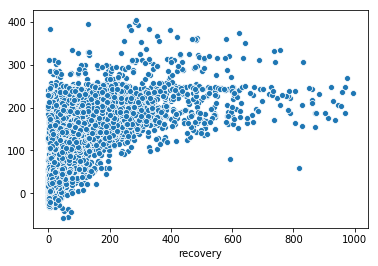

In [33]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']


# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_df[X_vars].copy()                                                    
y = Mid_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [34]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_gross_perfs,2.817264e+02
scaled_oil_gravity,2.444181e+02
scaled_tvd,2.010903e+02
scaled_vintage,1.297018e+02
scaled_direction,9.313608e+01
scaled_formation,4.690717e+01
scaled_frac_stages,3.223164e+01
scaled_proppant_ppf,7.352747e+00
scaled_frac_fluid_gpf,7.289262e+00
scaled_lateral_class,7.135831e+00


#### Midland, horizontal wells only:

In [35]:
scaled_df.scaled_direction.value_counts()

0.0    6675
1.0    1213
Name: scaled_direction, dtype: int64

In [36]:
Mid_Hor_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0)]
Mid_Hor_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_vintage
4559,173.262002,0.0,0.875,0.303030,0.763158,1.0,0.000000,0.244096,0.480224,0.531634,0.000000,0.0,0.060800,0.648057,0.933333
4490,158.546500,0.0,0.375,0.628788,0.763158,1.0,0.000000,0.282671,0.407650,0.547838,0.357143,0.0,0.153250,0.572056,0.916667
5637,629.956618,0.0,0.375,0.628788,0.763158,1.0,0.692308,0.258758,0.330308,0.727701,0.657143,0.0,0.143708,0.645452,0.950000
4717,10.258667,0.0,0.875,0.738636,0.763158,1.0,0.615385,0.502017,0.448495,0.370479,0.000000,0.0,0.450615,0.618580,1.000000
1688,194.856502,0.0,0.875,0.852273,0.763158,1.0,0.538462,0.303993,0.518477,0.479414,0.000000,0.0,0.045968,0.581435,0.933333


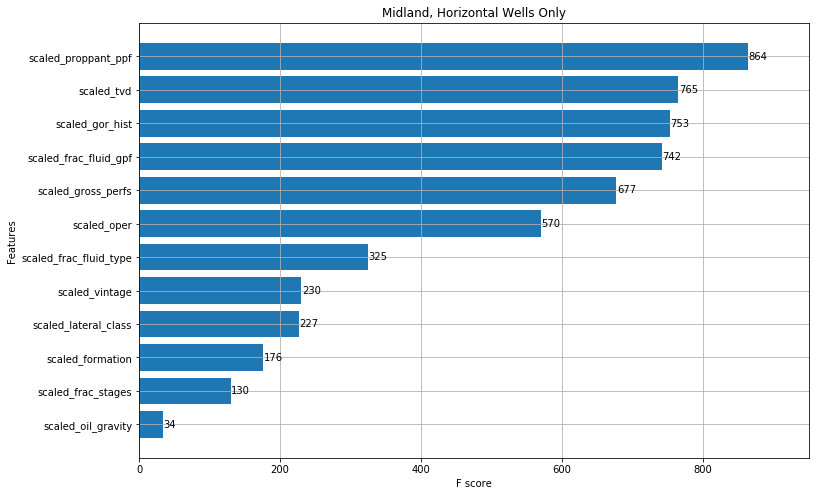

In [37]:
xgb_df = Mid_Hor_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Hor_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Horizontal Wells Only')
plt.show()

lr.intercept: 64.7083995167661
MAE: 54.68353455579048
MSE: 15009.337887693187
r2_train: 0.15419325578396048


,value
scaled_gross_perfs,2.977495e+02
scaled_oil_gravity,2.746513e+02
scaled_tvd,2.194427e+02
scaled_formation,6.038404e+01
scaled_proppant_ppf,1.917639e+01
scaled_lateral_class,1.204866e+01
scaled_frac_fluid_gpf,1.032400e+01
scaled_frac_fluid_type,2.726158e+00
scaled_direction,0.000000e+00
scaled_sub_basin,-7.105427e-14


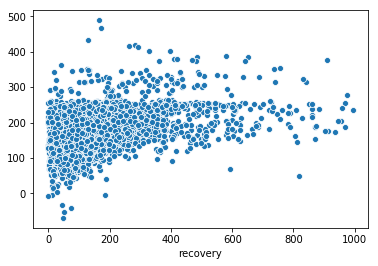

In [38]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars].copy()                                                    
y = Mid_Hor_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [39]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_gross_perfs,2.977495e+02
scaled_oil_gravity,2.746513e+02
scaled_vintage,2.628575e+02
scaled_tvd,2.194427e+02
scaled_formation,6.038404e+01
scaled_frac_stages,3.754883e+01
scaled_proppant_ppf,1.917639e+01
scaled_lateral_class,1.204866e+01
scaled_frac_fluid_gpf,1.032400e+01
scaled_frac_fluid_type,2.726158e+00


#### Midland, vertical wells only:

In [40]:
Mid_Ver_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 1.0)]
Mid_Ver_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_vintage
1355,7.480667,1.0,0.375,0.011364,0.763158,1.0,0.461538,0.071671,0.126718,0.013258,0.000000,0.0,0.123462,0.0,0.883333
737,11.410000,1.0,0.375,0.011364,0.157895,1.0,1.000000,0.043305,0.077524,0.088237,0.000000,0.0,0.109762,0.0,0.816667
3944,99.246833,1.0,0.625,0.708333,0.157895,1.0,0.461538,0.130631,0.086533,0.011048,0.014286,0.0,0.355366,0.0,0.233333
1568,26.071000,1.0,0.250,0.973485,0.763158,1.0,0.461538,0.733201,0.005094,0.011490,0.000000,0.0,0.181651,0.0,0.700000
1420,1.487667,1.0,0.000,0.776515,0.552632,1.0,0.461538,0.013447,0.017928,0.050085,0.000000,0.0,0.006947,0.0,0.883333


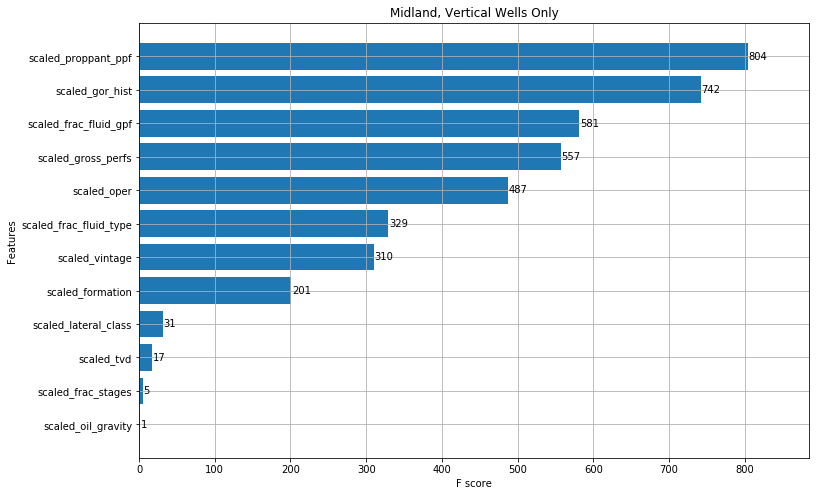

In [41]:
xgb_df = Mid_Ver_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Ver_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Vertical Wells Only')
plt.show()

lr.intercept: 82.83829445057145
MAE: 15.611440891095846
MSE: 1107.630525670803
r2_train: 0.34187757443133404


,value
scaled_gross_perfs,3.391570e+02
scaled_tvd,4.465512e+01
scaled_frac_fluid_gpf,3.214629e+01
scaled_gor_hist,3.135275e+01
scaled_formation,2.864023e+01
scaled_sub_basin,4.689582e-13
scaled_direction,0.000000e+00
scaled_oper,-1.805753e+00
scaled_frac_fluid_type,-3.366076e+00
scaled_proppant_ppf,-1.214794e+01


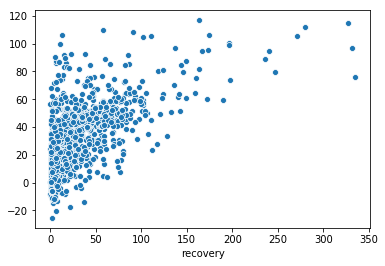

In [42]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Ver_df[X_vars].copy()                                                    
y = Mid_Ver_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [43]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_gross_perfs,3.391570e+02
scaled_frac_stages,2.224490e+02
scaled_vintage,1.099720e+02
scaled_tvd,4.465512e+01
scaled_oil_gravity,3.735734e+01
scaled_frac_fluid_gpf,3.214629e+01
scaled_gor_hist,3.135275e+01
scaled_formation,2.864023e+01
scaled_lateral_class,2.232159e+01
scaled_proppant_ppf,1.214794e+01


#### Midland, Horizontal Wells, Gross Perforations < 6000:

In [44]:
Mid_Hor_Low_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0) & (scaled_df['scaled_gross_perfs'] < gross_perfs_scaled_limit)]
Mid_Hor_Low_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_vintage
4676,93.897012,0.0,0.375,0.268939,0.763158,1.0,0.615385,0.442209,0.428135,0.385947,0.557143,0.0,0.128551,0.503350,0.933333
3831,34.160669,0.0,0.375,0.162879,0.763158,1.0,0.153846,0.503829,0.710250,0.338956,0.000000,0.0,0.150461,0.711851,0.983333
623,107.647177,0.0,0.375,0.196970,0.631579,1.0,0.153846,0.232060,0.475232,0.350888,0.000000,0.0,0.049684,0.641134,0.933333
2470,187.661178,0.0,0.375,0.579545,0.763158,1.0,0.615385,0.267982,0.335331,0.426604,0.000000,0.0,0.092812,0.722793,0.933333
2732,97.705500,0.0,0.875,0.250000,0.631579,1.0,0.615385,0.335089,0.532307,0.391765,0.000000,0.0,0.060546,0.678726,0.966667


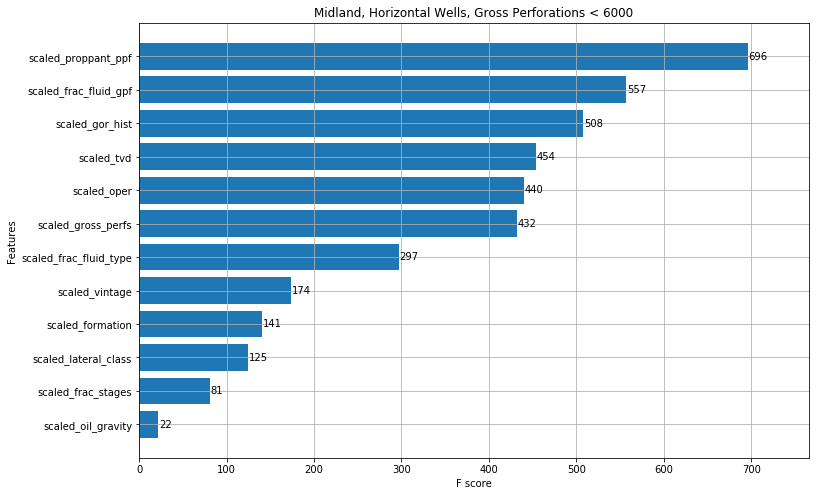

In [45]:
xgb_df = Mid_Hor_Low_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Hor_Low_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Horizontal Wells, Gross Perforations < 6000')
plt.show()

lr.intercept: -52.78935075369505
MAE: 39.93256498030948
MSE: 6014.6694961356
r2_train: 0.15971920014228647


,value
scaled_gross_perfs,228.160316
scaled_tvd,150.517774
scaled_oil_gravity,126.380584
scaled_proppant_ppf,60.559306
scaled_lateral_class,25.239382
scaled_gor_hist,22.116985
scaled_frac_fluid_gpf,19.461137
scaled_direction,0.000000
scaled_sub_basin,0.000000
scaled_formation,-1.511435


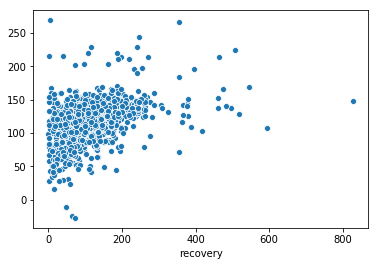

In [46]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_Low_df[X_vars].copy()                                                    
y = Mid_Hor_Low_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [47]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_gross_perfs,228.160316
scaled_tvd,150.517774
scaled_oil_gravity,126.380584
scaled_proppant_ppf,60.559306
scaled_vintage,36.236265
scaled_lateral_class,25.239382
scaled_gor_hist,22.116985
scaled_frac_stages,20.793786
scaled_frac_fluid_gpf,19.461137
scaled_frac_fluid_type,14.594320


#### Midland, Horizontal Wells, Gross Perforations > 6000:

In [48]:
((scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0) & (scaled_df['scaled_gross_perfs'] < gross_perfs_scaled_limit)).sum()

1144

In [49]:
((scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0) & (scaled_df['scaled_gross_perfs'] > gross_perfs_scaled_limit)).sum()

3841

In [50]:
Mid_Hor_High_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0) & (scaled_df['scaled_gross_perfs'] > gross_perfs_scaled_limit)]
Mid_Hor_High_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_vintage
6057,244.318333,0.0,0.375,0.628788,0.815789,1.0,0.692308,0.726605,0.023827,0.722840,0.014286,0.0,0.065848,0.693985,0.983333
1918,169.331848,0.0,0.000,0.765152,0.763158,1.0,0.384615,0.255533,0.235259,0.593798,0.000000,0.0,0.776768,0.499628,0.900000
1191,348.201000,0.0,0.875,0.465909,0.763158,1.0,0.076923,0.461310,0.780206,0.785741,0.000000,0.0,0.156331,0.578681,0.966667
4702,72.355338,0.0,0.875,0.465909,0.763158,1.0,0.000000,0.281656,0.472970,0.526110,0.000000,0.0,0.392068,0.604883,0.933333
4790,153.850506,0.0,0.375,0.628788,0.763158,1.0,0.076923,0.242511,0.564733,0.772851,1.000000,0.0,0.085013,0.638455,0.950000


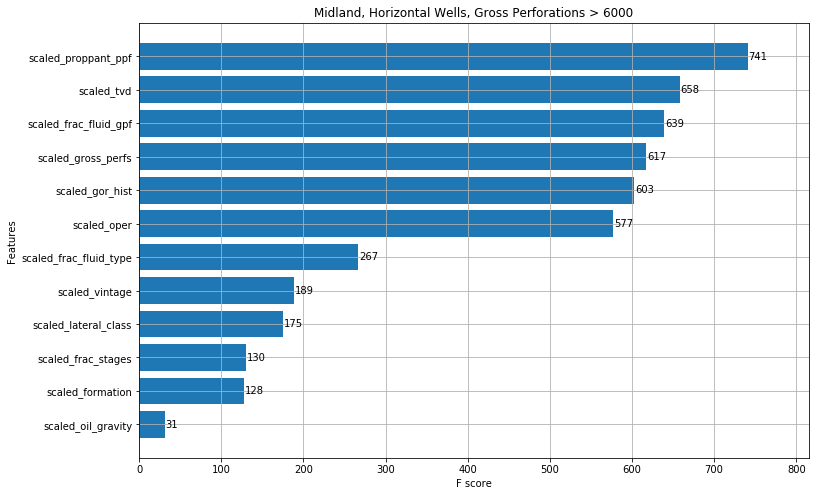

In [51]:
xgb_df = Mid_Hor_High_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Hor_High_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Horizontal Wells, Gross Perforations > 6000')
plt.show()

lr.intercept: 240.94060160060425
MAE: 60.36553713331277
MSE: 17345.60710953341
r2_train: 0.12748477864898533


,value
scaled_tvd,3.859113e+02
scaled_oil_gravity,3.531408e+02
scaled_gross_perfs,2.795681e+02
scaled_gor_hist,3.496192e+01
scaled_formation,2.546057e+01
scaled_frac_fluid_type,2.309478e+01
scaled_lateral_class,1.385950e+01
scaled_proppant_ppf,9.343174e+00
scaled_frac_fluid_gpf,2.837684e+00
scaled_sub_basin,1.136868e-13


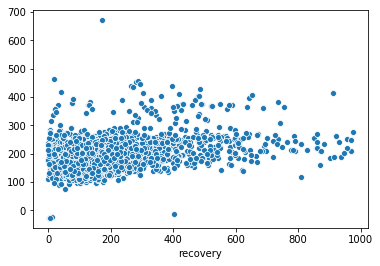

In [52]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_High_df[X_vars].copy()                                                    
y = Mid_Hor_High_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [53]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_vintage,5.224592e+02
scaled_tvd,3.859113e+02
scaled_oil_gravity,3.531408e+02
scaled_gross_perfs,2.795681e+02
scaled_frac_stages,4.469386e+01
scaled_gor_hist,3.496192e+01
scaled_formation,2.546057e+01
scaled_frac_fluid_type,2.309478e+01
scaled_lateral_class,1.385950e+01
scaled_oper,1.030395e+01


## Test Harness and Options

# Need to add filter_columns for the following to work.

## Explore and select algorithms

In [ ]:
def lregressiontest(df,xfeatures,yfeature,train_size):
    y = df[yfeature]
    X = filter_columns(df,xfeatures)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    column_names = X_train.columns
    r_and_p_values = [pearsonr(X_train[col], y_train) for col in column_names]
    corrdict = dict(zip(column_names, r_and_p_values))

    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    lm1 = LinearRegression(fit_intercept=False) 
    lm1.fit(X_train[xfeatures], y_train)
    LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
    lm1_y_intercept = lm1.intercept_
    lm1_coefficients = lm1.coef_
    y_pred_lm1 = lm1.predict(X_train[xfeatures])
    mse = mean_squared_error(y_train, y_pred_lm1)
    r2 = r2_score(y_train, y_pred_lm1)
    return mse, r2, corrdict


In [ ]:
X_vars = ['proppant_ppf', 'gor_hist', 'frac_fluid_gpf', 
          'months_active', 'lateral_len', 'ip90_boeqpd', 'county']

lregressiontest(scaled_df, X_vars, 'recovery', .8)

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering